In [1]:
%matplotlib inline
import os
os.environ['PY3_PROD'] = '1'
%load_ext autoreload
%autoreload 2
os.system('kinit')

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import copy
import numpy as np
import math
import matplotlib as mpl
import matplotlib.dates as dates
import matplotlib.pyplot as plt
import datetime
import itertools
import pandas as pd
import pickle

import sys
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

sys.path.append("C:/dev/pyktrader3/")
sys.path.append("C:/dev/wtpy/")
sys.path.append("C:/dev/akshare/")
sys.path.append("C:/dev/wtdev/")

from pycmqlib3.analytics.tstool import *
from pycmqlib3.analytics.btmetrics import *
from pycmqlib3.analytics.backtest_utils import *

import pypfopt
from pypfopt import plotting
from pypfopt import risk_models
from pypfopt import EfficientFrontier
from pypfopt import expected_returns

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
mpl.rcParams['figure.figsize'] = (12, 8)

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
display(HTML("<style>div.output_scroll { height: 44em; }</style>"))

In [8]:
# S = risk_models.CovarianceShrinkage((dpnl_df/5000000), returns_data=True, frequency=243).ledoit_wolf()
# plotting.plot_covariance(S, plot_correlation=True)

# mu = expected_returns.capm_return((dpnl_df/5000000), returns_data=True, frequency=243)
# mu.plot.barh(figsize=(8,6))

In [4]:
data_file = open('port_data_test.pkl', 'rb')
port_data = pickle.load(data_file)
data_file.close()

bt_empirics = port_data['empirics']
scen_stats = port_data['scen_stats']
scen_names = port_data['scen_names']
holdings = port_data['holdings']


In [5]:
scen_start = pd.to_datetime('2011-01-01')
df_list = []

run_key = 'hot_test'
for scen_name, scen_stat in zip(scen_names[run_key], scen_stats[run_key]):
    #scen_stat['portfolio_cumpnl'][scen_start:].plot(title=scen_name)
    #plt.show()
    ts = scen_stat['portfolio_pnl'][scen_start:]    
    df_list.append(ts)
dpnl_df = pd.concat(df_list, axis=1, join='outer').fillna(0)
dpnl_df.columns = scen_names[run_key]
#scen_corr = dpnl_df.corr()

strat_list = scen_names[run_key]
print(strat_list)

['tscarry-ryieldnmb-1-122-1', 'tscarry-ryieldqtl-1-20-1', 'tscarry-ryieldqtl-1-60-1', 'tscarry-ryieldqtl-1-244-1', 'tscarry-basmomnma-20-122-1', 'tscarry-basmomnma-60-122-1', 'tscarry-basmomnma-120-122-1', 'tscarry-basmomnma-180-122-1', 'tscarry-basmomqtl-120-20-1', 'tscarry-basmomqtl-240-20-1', 'xscarry-rank-ryieldnma-1-122-1', 'xscarry-rank-basmomnma-20-122-1', 'xscarry-rank-basmomnma-100-122-1', 'xscarry-rank-basmomnma-170-122-1', 'tsmom-hlbrk-20-1-10', 'tsmom-hlbrk-61-1-10', 'tsmom-hlbrk-244-1-10', 'tsmom-macdnma-8-160-5', 'tsmom-macdnma-16-160-5', 'tsmom-macdnma-24-160-5', 'xsmom-rank-hlbrk-20-1-1', 'xsmom-rank-hlbrk-61-1-1', 'xsmom-rank-hlbrk-244-1-1', 'xsmom-rank-momnma-10-10-1', 'xsmom-rank-momnma-130-120-1', 'xsmom-rank-momnma-240-60-1', 'custom-hc_rb_diff-20-122-1', 'custom-leader_lagger-40-122-1']


In [9]:
strat_list = scen_names[run_key]

sector_mapper = {}
for strat in strat_list:
    strat_split = strat.split('-')
    strat_type = strat_split[0]
    strat_fact = strat_split[1]
    if strat_type in ['tsmom', 'xsmom']:
        sector_mapper[strat] = strat_type
    elif strat_type == 'tscarry':
        if strat_fact[:6] == 'ryield':
            sector_mapper[strat] = 'tsbasis'
        elif strat_fact[:6] == 'basmom':
            sector_mapper[strat] = 'tsbasmom'
    elif strat_type == 'xscarry':
        strat_fact = strat_split[2]
        if strat_fact[:6] == 'ryield':
            sector_mapper[strat] = 'xsbasis'
        elif strat_fact[:6] == 'basmom':
            sector_mapper[strat] = 'xsbasmom'
    elif strat_type == 'custom':
        if strat_fact == 'leader_lagger':
            sector_mapper[strat] = 'macro2'
        elif strat_fact == 'hc_rb_diff':
            sector_mapper[strat] = 'macro1'
    else:
        print("unsupported mapping %s" % (strat))

#print(sector_mapper)

pnl_df = (dpnl_df/5000000).copy()
pnl_df.columns = pd.MultiIndex.from_tuples([(col, sector_mapper[col]) for col in pnl_df.columns], names=['strat', 'sector'])

unitary_df = pnl_df/(pnl_df['2018-01-01':].std())

unitary_df

strat,tscarry-ryieldnmb-1-122-1,tscarry-ryieldqtl-1-20-1,tscarry-ryieldqtl-1-60-1,tscarry-ryieldqtl-1-244-1,tscarry-basmomnma-20-122-1,tscarry-basmomnma-60-122-1,tscarry-basmomnma-120-122-1,tscarry-basmomnma-180-122-1,tscarry-basmomqtl-120-20-1,tscarry-basmomqtl-240-20-1,xscarry-rank-ryieldnma-1-122-1,xscarry-rank-basmomnma-20-122-1,xscarry-rank-basmomnma-100-122-1,xscarry-rank-basmomnma-170-122-1,tsmom-hlbrk-20-1-10,tsmom-hlbrk-61-1-10,tsmom-hlbrk-244-1-10,tsmom-macdnma-8-160-5,tsmom-macdnma-16-160-5,tsmom-macdnma-24-160-5,xsmom-rank-hlbrk-20-1-1,xsmom-rank-hlbrk-61-1-1,xsmom-rank-hlbrk-244-1-1,xsmom-rank-momnma-10-10-1,xsmom-rank-momnma-130-120-1,xsmom-rank-momnma-240-60-1,custom-hc_rb_diff-20-122-1,custom-leader_lagger-40-122-1
sector,tsbasis,tsbasis,tsbasis,tsbasis,tsbasmom,tsbasmom,tsbasmom,tsbasmom,tsbasmom,tsbasmom,xsbasis,xsbasmom,xsbasmom,xsbasmom,tsmom,tsmom,tsmom,tsmom,tsmom,tsmom,xsmom,xsmom,xsmom,xsmom,xsmom,xsmom,macro1,macro2
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-01-05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-11,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-24,-0.794717,-0.884378,-1.569044,-0.214890,-0.706943,-0.263692,0.967900,-0.277040,-0.768532,-0.698007,0.214280,0.783065,1.224203,0.284525,0.277308,1.459061,0.954354,0.071352,1.118799,1.297285,-0.422393,0.306300,-0.240600,-0.526396,-0.849207,0.576313,0.121168,0.813017
2023-04-25,-1.113805,-0.450222,-1.141428,-0.026292,-0.301059,-0.997898,0.253786,-0.611006,-0.636722,1.067782,-0.261075,0.113115,0.011050,-0.388096,0.844380,0.796375,-0.105476,0.674006,0.732918,0.536631,0.971178,0.351353,-1.048709,0.753285,-0.797854,0.029699,0.729314,0.741862


In [14]:
unitary_df['2020-01-01':].std()

strat                             sector  
tscarry-ryieldnmb-1-122-1         tsbasis     1.119496
tscarry-ryieldqtl-1-20-1          tsbasis     1.054542
tscarry-ryieldqtl-1-60-1          tsbasis     1.081096
tscarry-ryieldqtl-1-244-1         tsbasis     1.120729
tscarry-basmomnma-20-122-1        tsbasmom    1.027317
tscarry-basmomnma-60-122-1        tsbasmom    1.052866
tscarry-basmomnma-120-122-1       tsbasmom    1.017561
tscarry-basmomnma-180-122-1       tsbasmom    0.933734
tscarry-basmomqtl-120-20-1        tsbasmom    1.050122
tscarry-basmomqtl-240-20-1        tsbasmom    1.065785
xscarry-rank-ryieldnma-1-122-1    xsbasis     1.009884
xscarry-rank-basmomnma-20-122-1   xsbasmom    0.988154
xscarry-rank-basmomnma-100-122-1  xsbasmom    0.962757
xscarry-rank-basmomnma-170-122-1  xsbasmom    0.965820
tsmom-hlbrk-20-1-10               tsmom       1.112552
tsmom-hlbrk-61-1-10               tsmom       1.156116
tsmom-hlbrk-244-1-10              tsmom       1.174895
tsmom-macdnma-8-160-5 

In [7]:
pnl_tenors = ['6m', '1y', '2y', '3y', '4y', '5y', '6y', '7y', '8y', '10y']

perf_dict = {}
for sector in unitary_df.columns.get_level_values(1).unique():
    sector_pnl = unitary_df.loc[:, unitary_df.columns.get_level_values(1) == sector].mean(axis=1)
    res = calc_perf_by_tenors(sector_pnl, pnl_tenors, metric='sharpe')
    perf_dict[sector] = res

perf_df = pd.DataFrame(perf_dict)
perf_df

,tsbasis,tsbasmom,xsbasis,xsbasmom,tsmom,xsmom,macro1,macro2
sharpe_6m,-0.121799,0.366335,-0.493241,0.877661,-1.561689,-2.251158,2.697716,0.725708
sharpe_1y,0.094333,0.904665,-0.062023,1.240293,-0.722794,-0.996454,2.650172,1.142350
sharpe_2y,0.966843,1.355280,0.587669,1.283232,0.467233,0.186610,1.495918,1.501338
sharpe_3y,1.860258,2.116931,1.378121,1.988859,1.439491,1.181594,2.304443,2.246584
sharpe_4y,2.200553,1.994261,1.350156,1.795226,1.273282,1.257677,2.277285,1.984646
sharpe_5y,2.029947,1.953983,1.553632,1.853092,1.113806,1.152984,2.017324,1.944161
sharpe_6y,1.846730,1.885618,1.594182,1.810632,0.956732,1.089451,1.724427,1.795952
sharpe_7y,1.941842,2.034057,1.566006,1.785800,0.955678,0.973996,1.662833,1.700797
sharpe_8y,1.785811,1.866116,1.546437,1.817428,1.123046,1.032928,1.708342,1.873575
sharpe_10y,1.924958,1.951335,1.604927,1.867455,1.136081,1.243673,1.586570,1.777729


strat                                     tscarry-ryieldnmb-1-122-1  \
sector                                                      tsbasis   
strat                            sector                               
tscarry-ryieldnmb-1-122-1        tsbasis                   1.000000   
tscarry-ryieldqtl-1-20-1         tsbasis                   0.452294   
tscarry-ryieldqtl-1-60-1         tsbasis                   0.552924   
tscarry-ryieldqtl-1-244-1        tsbasis                   0.615275   
tscarry-basmomnma-20-122-1       tsbasmom                  0.487800   
tscarry-basmomnma-60-122-1       tsbasmom                  0.530741   
tscarry-basmomnma-120-122-1      tsbasmom                  0.405145   
tscarry-basmomnma-180-122-1      tsbasmom                  0.328269   
tscarry-basmomqtl-120-20-1       tsbasmom                  0.355052   
tscarry-basmomqtl-240-20-1       tsbasmom                  0.311482   
xscarry-rank-ryieldnma-1-122-1   xsbasis                   0.683603   
xscarr

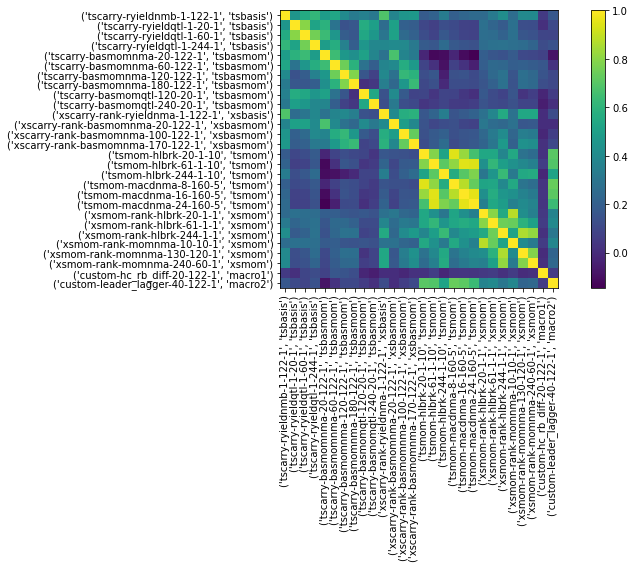

In [15]:
sample_cov = risk_models.sample_cov(unitary_df, returns_data=True, frequency=243)
plotting.plot_covariance(sample_cov, plot_correlation=True)
print(unitary_df.corr())

In [29]:
opt_weights = {}
mv_series = {}
factor_list = ['tsbasis', 'tsbasmom', 'tsmom', 'xsbasmom', 'xsmom', 'xsbasis', 'macro1', 'macro2']
for sector in factor_list:
    sector_df = unitary_df.loc[:, unitary_df.columns.get_level_values(1) == sector]
    ew_perf = calc_perf_by_tenors(sector_df.mean(axis=1), pnl_tenors, metric='sharpe')
    if len(sector_df.columns) > 1:
        #mu = expected_returns.mean_historical_return(sector_df, returns_data=True, frequency=243)
        S = risk_models.CovarianceShrinkage(sector_df, returns_data=True, frequency=243).ledoit_wolf()
        #ef = EfficientFrontier(mu, S, weight_bounds=(0,1))
        #ef.max_sharpe()
        ef = EfficientFrontier(None, S, weight_bounds=(0,1))
        ef.min_volatility()
        weights = ef.clean_weights()
        opt_weights[sector] = weights
        mv_pnl = sector_df.multiply(pd.DataFrame(weights, index=sector_df.index)).sum(axis=1)
    else:
        mv_pnl = sector_df.mean(axis=1) 
    mv_perf = calc_perf_by_tenors(mv_pnl, pnl_tenors, metric='sharpe')
    print(f"{sector} weights:\n{weights}\n equal weight: {ew_perf}\n min var: {mv_perf}\n")        
    mv_series[sector] = mv_pnl
        
mv_series = pd.DataFrame(mv_series)
mv_series

tsbasis weights:
OrderedDict([(('tscarry-ryieldnmb-1-122-1', 'tsbasis'), 0.43742), (('tscarry-ryieldqtl-1-20-1', 'tsbasis'), 0.29742), (('tscarry-ryieldqtl-1-60-1', 'tsbasis'), 0.0), (('tscarry-ryieldqtl-1-244-1', 'tsbasis'), 0.26516)])
 equal weight: sharpe_6m    -0.125183
sharpe_1y     0.089339
sharpe_2y     0.965057
sharpe_3y     1.859434
sharpe_4y     2.199245
sharpe_5y     2.029284
sharpe_6y     1.846966
sharpe_7y     1.942116
sharpe_8y     1.786392
sharpe_10y    1.925262
Name: 0, dtype: float64
 min var: sharpe_6m     0.104148
sharpe_1y     0.017057
sharpe_2y     1.038353
sharpe_3y     1.967040
sharpe_4y     2.195821
sharpe_5y     2.029857
sharpe_6y     1.910844
sharpe_7y     2.006206
sharpe_8y     1.879910
sharpe_10y    1.979143
Name: 0, dtype: float64

tsbasmom weights:
OrderedDict([(('tscarry-basmomnma-20-122-1', 'tsbasmom'), 0.03608), (('tscarry-basmomnma-60-122-1', 'tsbasmom'), 0.1114), (('tscarry-basmomnma-120-122-1', 'tsbasmom'), 0.08386), (('tscarry-basmomnma-180-122-1', 

,tsbasis,tsbasmom,tsmom,xsbasmom,xsmom,xsbasis,macro1,macro2
date,,,,,,,,
2011-01-05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-11,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...
2023-04-24,-0.667637,-0.412659,0.672947,0.690267,-0.211125,0.214280,0.121168,0.813017
2023-04-25,-0.628077,-0.268409,0.395363,-0.094666,0.281077,-0.261075,0.729314,0.741862
2023-04-26,-0.025339,-0.120205,-0.129698,0.133977,-0.338387,0.653460,-0.021274,0.138654


In [25]:
mv_series['2017-01-01':].corr()

,tsbasis,tsbasmom,tsmom,xsbasmom,xsmom,xsbasis,macro1,macro2
tsbasis,1.000000,0.699015,0.320944,0.559610,0.435199,0.569845,0.073087,0.202403
tsbasmom,0.699015,1.000000,0.147713,0.691662,0.353774,0.431967,0.046680,0.113216
tsmom,0.320944,0.147713,1.000000,0.267218,0.623984,0.308542,0.062671,0.708063
xsbasmom,0.559610,0.691662,0.267218,1.000000,0.464192,0.596746,-0.013416,0.077642
xsmom,0.435199,0.353774,0.623984,0.464192,1.000000,0.554995,0.060705,0.373287
xsbasis,0.569845,0.431967,0.308542,0.596746,0.554995,1.000000,0.028862,0.124372
macro1,0.073087,0.046680,0.062671,-0.013416,0.060705,0.028862,1.000000,0.075114
macro2,0.202403,0.113216,0.708063,0.077642,0.373287,0.124372,0.075114,1.000000


In [36]:
# mu = expected_returns.ema_historical_return(mv_series, returns_data=True, frequency=243, span=243*5,)
# print(mu)

S = risk_models.CovarianceShrinkage(mv_series, returns_data=True, frequency=243).ledoit_wolf()
# ef = EfficientFrontier(mu, S, weight_bounds=(0,1))
# ef.max_sharpe()

ef = EfficientFrontier(None, S, weight_bounds=(0,1))

fact_idx = {}

for fact in factor_list:
    fact_idx[fact] = ef.tickers.index(fact)

for fact in ['tsbasis', 'tsbasmom', 'tsmom', 'xsbasmom', 'xsmom', 'xsbasis']:
    ef.add_constraint(lambda w: w[fact_idx[fact]] >= 0.1)
    ef.add_constraint(lambda w: w[fact_idx[fact]] <= 0.25)

ef.add_constraint(lambda w: w[fact_idx['macro1']] <= 0.15)
ef.add_constraint(lambda w: w[fact_idx['tsmom']] + w[fact_idx['macro2']] <= 0.25)
ef.add_constraint(lambda w: w[fact_idx['tsbasmom']] + w[fact_idx['xsbasmom']] <= 0.4)
ef.add_constraint(lambda w: w[fact_idx['tsbasmom']] + w[fact_idx['xsbasmom']] <= 0.4)

ef.min_volatility()
port_weights = ef.clean_weights()
port_weights

OrderedDict([('tsbasis', 0.1),
             ('tsbasmom', 0.22438),
             ('tsmom', 0.1),
             ('xsbasmom', 0.1),
             ('xsmom', 0.1),
             ('xsbasis', 0.1),
             ('macro1', 0.15),
             ('macro2', 0.12562)])

In [37]:
mvport_pnl = mv_series.multiply(pd.DataFrame(port_weights, index=mv_series.index)).sum(axis=1)
mvport_perf = calc_perf_by_tenors(mvport_pnl, pnl_tenors, metric='sharpe')
mvport_perf

sharpe_6m     0.718855
sharpe_1y     1.539937
sharpe_2y     1.962260
sharpe_3y     3.265971
sharpe_4y     3.028386
sharpe_5y     2.908995
sharpe_6y     2.753279
sharpe_7y     2.759966
sharpe_8y     2.837751
sharpe_10y    2.875579
Name: 0, dtype: float64

<AxesSubplot:xlabel='date'>

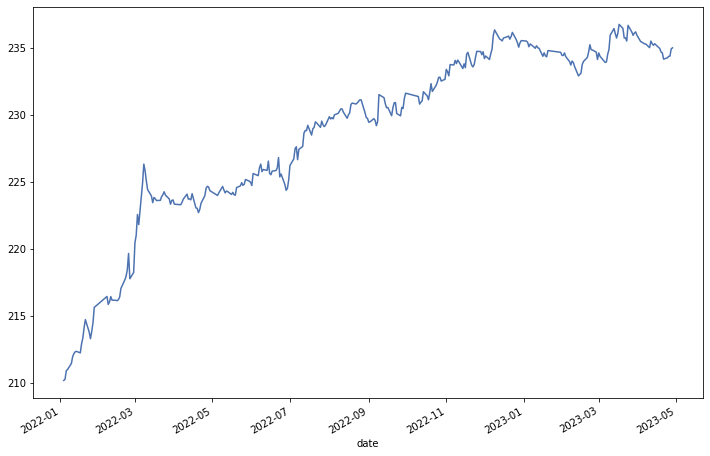

In [38]:
mvport_pnl.cumsum()['2022-01-01':].plot()

In [32]:
fact_idx = {}

for fact in factor_list:
    fact_idx[fact] = ef.tickers.index(fact)
fact_idx

{'tsbasis': 0,
 'tsbasmom': 1,
 'tsmom': 2,
 'xsbasmom': 3,
 'xsmom': 4,
 'xsbasis': 5,
 'macro1': 6,
 'macro2': 7}